### Objetivo

O objetivo deste projeto é desenvolver um modelo de machine learning para prever se um **colaborador de uma empresa deixará o emprego**.. Com base nessas previsões, a empresa poderá identificar colaboradores em risco e implementar ações preventivas. O foco principal é **aumentar a métrica de recall**, priorizando a identificação correta de saídas potenciais, mesmo que isso resulte em alguns falsos positivos.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import RFECV

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from imblearn.under_sampling import NearMiss

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score

In [2]:
df = pd.read_csv('HR_comma_sep.csv')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [4]:
(df=='').sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
Department               0
salary                   0
dtype: int64

### Análise Exploratória (EDA)

**Balanceamento:**
- A **variável alvo está desbalanceada** no dataset. Cerca de 76% dos colaboradores continuam na empresa, enquanto 24% já saíram.

**Correlação:**
- A matriz de correlação mostra que **não há relações lineares fortes** entre as variáveis independentes e a variável dependente ('left'). Portanto, **algorítimos baseados em árvore** podem captar relação não lineares, como o RandomForest

**Nível de satisfação**
- Avaliando os níveis de satisfação e comparando-os com a saída ou não dos colaboradores, é possível notar que **colaboradores com nível de satisfação maior tendem a continuar na empresa**, comprovado pelo teste de hipótese.
- O **Teste de Mann-Whitney** foi aplicado pois não se pode assumir normalidade na distribuição dos dados, além de considerar que o dataset é uma amostra limitada em um período de tempo. Portanto, não é possível afirmar que todo o dataset representa toda a população.

In [48]:
df.left.value_counts(True)

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64

In [49]:
num_features = df.drop(['left'], axis=1).select_dtypes(exclude=['object']).columns.tolist()
obj_features = df.select_dtypes(include=['object']).columns.tolist()
target = 'left'

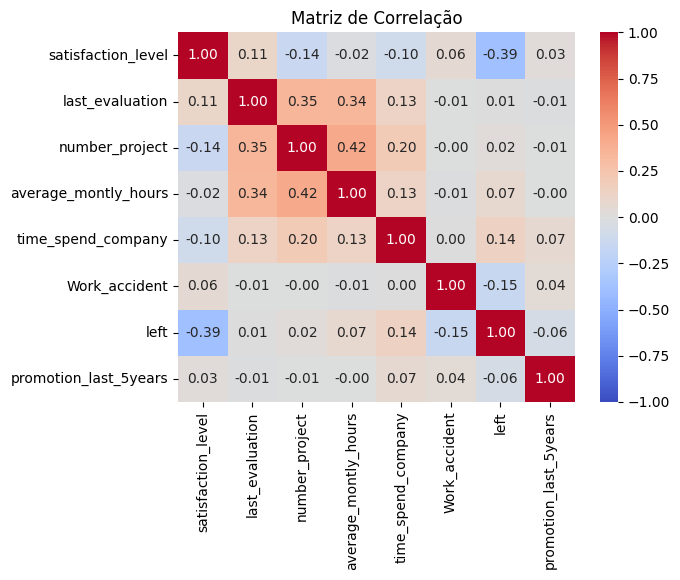

In [50]:
matriz_cor = df[df.select_dtypes(exclude=['object']).columns.tolist()].corr()
sns.heatmap(matriz_cor, vmin=-1, vmax=1, annot=True, fmt='.2f', cmap='coolwarm');
plt.title('Matriz de Correlação');

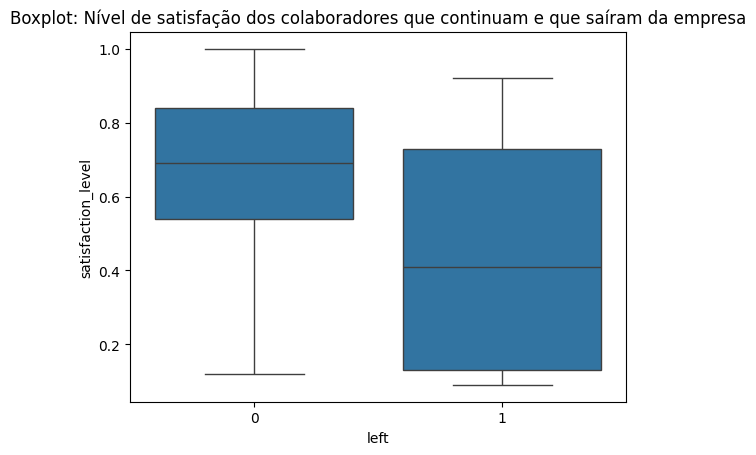

In [36]:
sns.boxplot(data=df, y='satisfaction_level', x='left')
plt.title('Boxplot: Nível de satisfação dos colaboradores que continuam e que saíram da empresa');

<Axes: xlabel='satisfaction_level', ylabel='Count'>

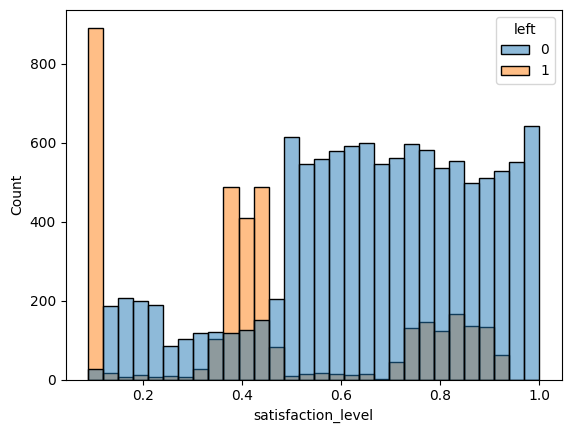

In [39]:
sns.histplot(data=df, x='satisfaction_level', hue='left')

### Aplicando o Teste de Mann-Whitney

H0: media_continuam <= media_saem

H1: media_continuam > media_saem

In [44]:
continuam = df[df['left'] == 0]['satisfaction_level'].values
saem = df[df['left'] == 1]['satisfaction_level'].values

from scipy.stats import mannwhitneyu

_, p = mannwhitneyu(continuam, saem, alternative='greater')

if (p <= 0.05):
    print('Rejeitar H0: media_continuam > media_saem')
else:
    print('Não rejeita-se H0, pois não evidências para rejeitar H0 em favor de H1: media_continuam <= media_saem')

Rejeitar H0: media_continuam > media_saem


### Dividindo os dados

In [51]:
labelencoder = LabelEncoder()

X = df.drop([target], axis=1)
y = labelencoder.fit_transform(df[target])

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Modelagem

**Escolha da métrica de desempenho:**
- O objetivo é aumentar a performance do **recall**, visto que o problema de negócio ressalta a importância de prever corretamente as pessoas que irão sair da empresa para promover ações. 
- É preferível mover ações em pessoas que não iriam deixar a empresa do que não promover ações em pessoas que realmente vão deixar a empresa.

**Pré-Processamento:**
- Variáveis nominais como **Department** foram codificadas com OneHotEncoder.
- A variável ordinal **salary** foi codificada respeitando sua hierarquia (“low”, “medium”, “high”).
- O método **Nearmiss** foi utilizado para balancear as classes reduzindo a classe majoritária
- O algoritmo **K-Means** foi aplicado para criar uma representação categória da variável **satisfaction_level**, baseando a escolha de 'k' pelo método do cotovelo

**Modelo Inicial:**
- Algoritmo: Random Forest.
- Acurácia: 94%
- Precision: 98%
- Recall: 76%
- ROC-AUC: 88%

**Modelo Final (após otimizações):**
- Algoritmo: Random Forest.
- Acurácia: 97%
- Precision: 91%
- Recall: 96%
- ROC-AUC: 96%

In [53]:
onehot_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])

preprocessor = ColumnTransformer([
    ('num', 'passthrough', num_features),
    ('nominal', onehot_encoder, ['Department']),
    ('ordinal', ordinal_encoder, ['salary'])
])

In [54]:
rfc_1 = RandomForestClassifier(random_state=42, max_depth=5)

pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('modelo', rfc_1)
])

pipeline_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['satisfaction_level',
                                                   'last_evaluation',
                                                   'number_project',
                                                   'average_montly_hours',
                                                   'time_spend_company',
                                                   'Work_accident',
                                                   'promotion_last_5years']),
                                                 ('nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Department']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']]),
                                                  ['salary'])])),
                ('modelo',
                 RandomForestClassifier(max_depth=5, random_state=42))])

In [55]:
pipeline_1.named_steps['preprocessor'].get_feature_names_out().tolist() # a saida do modelo nao fornece get_features_names_out

['num__satisfaction_level',
 'num__last_evaluation',
 'num__number_project',
 'num__average_montly_hours',
 'num__time_spend_company',
 'num__Work_accident',
 'num__promotion_last_5years',
 'nominal__Department_IT',
 'nominal__Department_RandD',
 'nominal__Department_accounting',
 'nominal__Department_hr',
 'nominal__Department_management',
 'nominal__Department_marketing',
 'nominal__Department_product_mng',
 'nominal__Department_sales',
 'nominal__Department_support',
 'nominal__Department_technical',
 'ordinal__salary']

In [96]:
def metrics_model_without_search(model, X_train, y_train):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    scores = cross_validate(model, X_train, y_train, scoring=['precision', 'accuracy', 'recall', 'roc_auc'], cv= skf, n_jobs=-1, verbose=20)

    return scores

In [100]:
def metrics_model_test(model, X_train, y_train, X_test, y_test):
    
    y_pred_test = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    roc_auc = roc_auc_score(y_test, y_pred_test)

    print(f'Acurácia: {accuracy:.2f}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'ROC-AUC: {roc_auc:.2f}')

    sns.heatmap(confusion_matrix(y_test, y_pred_test), cmap='coolwarm', annot=True, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('Real')

In [15]:
metrics_model_without_search(pipeline_1, X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.0s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    4.0s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished


{'fit_time': array([0.76174116, 0.73734975, 0.70001984, 0.65687323, 0.75803757]),
 'score_time': array([0.06370473, 0.07421589, 0.06107736, 0.06796789, 0.06270337]),
 'test_precision': array([0.98072805, 0.98464912, 0.98275862, 0.98046875, 0.97968397]),
 'test_accuracy': array([0.94916667, 0.94625   , 0.97166667, 0.96666667, 0.93914131]),
 'test_recall': array([0.80210158, 0.78633975, 0.89685315, 0.87762238, 0.76007005]),
 'test_roc_auc': array([0.97040577, 0.9825357 , 0.9807721 , 0.97822193, 0.98669653])}

Acurácia: 0.94
Precision: 0.98
Recall: 0.76
ROC-AUC: 0.88


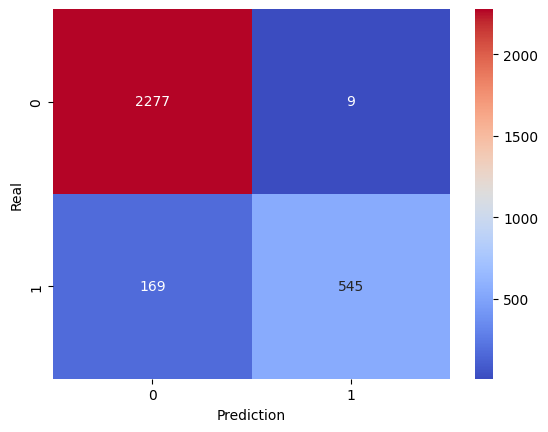

In [16]:
pipeline_1.fit(X_train, y_train)
metrics_model_test(pipeline_1, X_train, y_train, X_test, y_test)

### Busca por melhores hiperparâmetros

In [70]:
rfc = RandomForestClassifier(random_state=42)

params = {
    'modelo__max_depth':[5, 8, 10, 12], 
    'modelo__min_samples_split': [2, 5, 10],
    'modelo__min_samples_leaf': [2, 5, 10, 25, 50, 100]
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [74]:
rfc = RandomForestClassifier(random_state=42)

pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('modelo', rfc)
])

grid_2 = GridSearchCV(
    pipeline_2,
    param_grid=params,
    scoring='recall',
    cv=inner_cv,
    n_jobs=-1,
    verbose=20,
)

rfc_score = cross_validate(grid_2, X_train, y_train, scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=outer_cv, n_jobs=-1, verbose=20)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.8min finished


In [75]:
for i in rfc_score:
    print(f'{i}: {rfc_score[i].mean():.2f}')

fit_time: 167.09
score_time: 0.22
test_accuracy: 0.98
test_precision: 0.98
test_recall: 0.92
test_roc_auc: 0.99


In [21]:
grid_2.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['satisfaction_level',
                                                                          'last_evaluation',
                                                                          'number_project',
                                                                          'average_montly_hours',
                                                                          'time_spend_company',
                                                                          'Work_accident',
                                                                          'promotion_last_5years']),
                                                                        ('nominal',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Department']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(categories=[['low',
                                                                                                     'medium',
                                                                                                     'high']]),
                                                                         ['salary'])])),
                                       ('modelo',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'modelo__max_depth': [5, 8, 10, 12],
                         'modelo__min_samples_leaf': [2, 5, 10, 25, 50, 100],
                         'modelo__min_samples_split': [2, 5, 10]},
             scoring='recall', verbose=20)

In [22]:
grid_2.best_params_

{'modelo__max_depth': 12,
 'modelo__min_samples_leaf': 2,
 'modelo__min_samples_split': 2}

<BarContainer object of 18 artists>

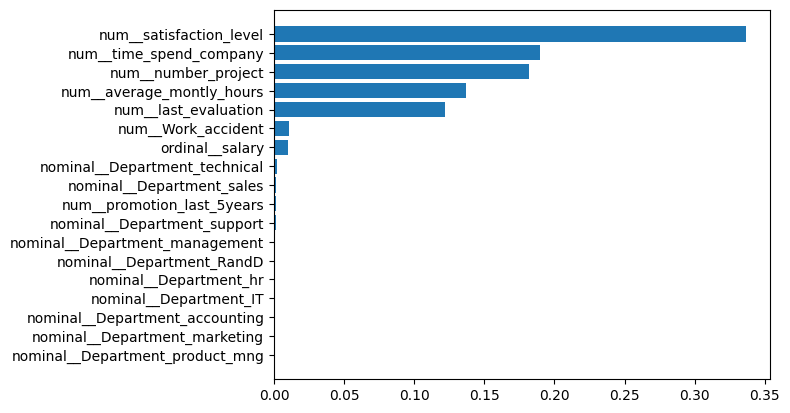

In [23]:
feature_importance = grid_2.best_estimator_.named_steps['modelo'].feature_importances_
feature_name = grid_2.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

feature_df = pd.DataFrame({'Feature': feature_name, 'Value': feature_importance}).sort_values(by='Value', ascending=True)

plt.barh(feature_df['Feature'], feature_df['Value'])

### Melhorando o resultado com:

1. Aplicando um **undersampling** para balanceamento das classes
2. Aplicar **kmeans** para clusterizar a coluna satisfaction_level (variável importante)
3. Aplicar a **seleção de features**

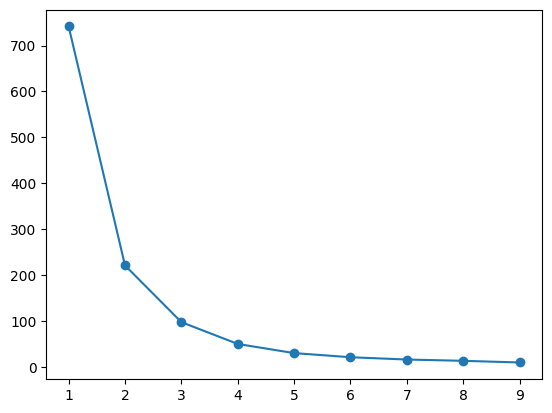

In [24]:
from sklearn.cluster import KMeans

X_cluster = X_train[['satisfaction_level']]

inertia = []

for k in range(1, 10):

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_cluster)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')

### Método do Cotovelo:

Como é possível notar no gráfico, o 'cotovelo' é formado com k = 3, portanto, será o escolhido para seguir com o modelo.

In [114]:
num_features = df.drop(['satisfaction_level', 'left'], axis=1).select_dtypes(exclude=['object']).columns.tolist()
kmeans_features = ['satisfaction_level']
cat_features = ['Department']
ord_features = ['salary']
target = 'left'

onehot_encoder = OneHotEncoder(handle_unknown='ignore')
ordinal_encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])

nm = NearMiss()

class KMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = None

    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans.fit(X)
        return self

    def transform(self, X):
        return self.kmeans.predict(X).reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return self.kmeans.feature_names_in_

preprocessor = ColumnTransformer([
    ('kmeans', KMeansTransformer(), kmeans_features),
    ('num', 'passthrough', num_features),
    ('nominal', onehot_encoder, cat_features),
    ('ordinal', ordinal_encoder, ord_features),
])

rfc = RandomForestClassifier(random_state=42, max_depth=5)

pipeline_3 = imbpipeline([
    ('preprocessor', preprocessor),
    ('undersample', nm),
    ('modelo', rfc)
])

pipeline_3.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('kmeans', KMeansTransformer(),
                                                  ['satisfaction_level']),
                                                 ('num', 'passthrough',
                                                  ['last_evaluation',
                                                   'number_project',
                                                   'average_montly_hours',
                                                   'time_spend_company',
                                                   'Work_accident',
                                                   'promotion_last_5years']),
                                                 ('nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Department']),
                                                 ('ordinal',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high']]),
                                                  ['salary'])])),
                ('undersample', NearMiss()),
                ('modelo',
                 RandomForestClassifier(max_depth=5, random_state=42))])

In [26]:
X_transformed = pipeline_3.named_steps['preprocessor'].fit_transform(X_train)
X_resampled, y_resampled = pipeline_3.named_steps['undersample'].fit_resample(X_transformed, y_train)

print('Tamanho dos dados após reamostragem: ', X_resampled.shape)
print('Verificando balanceamento após reamostragem:')
print(pd.Series(y_resampled).value_counts(True))

Tamanho dos dados após reamostragem:  (5714, 18)
Verificando balanceamento após reamostragem:
0    0.5
1    0.5
Name: proportion, dtype: float64


In [27]:
transformed_data = pipeline_3.named_steps['preprocessor'].fit_transform(X_train)
print("Shape dos dados transformados:", transformed_data.shape)
print("Shape dos dados originais:", X_train.shape)

Shape dos dados transformados: (11999, 18)
Shape dos dados originais: (11999, 9)


<BarContainer object of 18 artists>

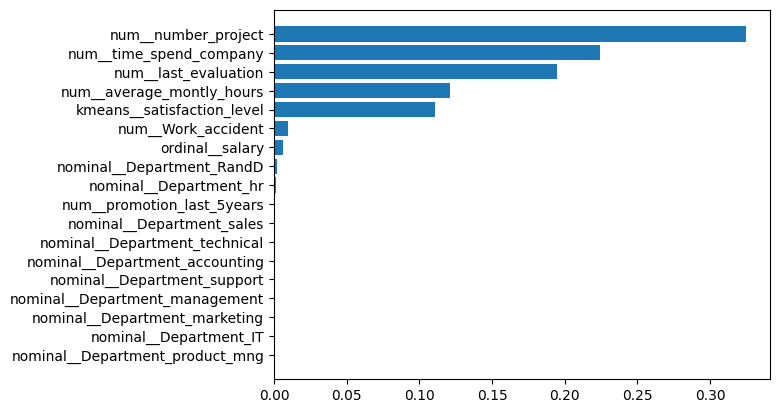

In [115]:
feature_importances_3 = pipeline_3.named_steps['modelo'].feature_importances_
feature_names_3 = pipeline_3.named_steps['preprocessor'].get_feature_names_out()

feature_importances_3_df = pd.DataFrame({'Feature': feature_names_3, 'Value': feature_importances_3}).sort_values(by=['Value'], ascending=True)

plt.barh(feature_importances_3_df['Feature'], feature_importances_3_df['Value'])

In [116]:
num_features = df.drop(['satisfaction_level', 'promotion_last_5years', 'left'], axis=1).select_dtypes(exclude=['object']).columns.tolist()
kmeans_features = ['satisfaction_level']
ord_features = ['salary']
target = 'left'
drop_features = ['Department', 'promotion_last_5years']

ordinal_encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])

nm = NearMiss()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfc = RandomForestClassifier(random_state=42, max_depth=5)

class KMeansTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=3, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = None

    def fit(self, X, y=None):
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        self.kmeans.fit(X)
        return self

    def transform(self, X):
        return self.kmeans.predict(X).reshape(-1, 1)

    def get_feature_names_out(self, input_features=None):
        return self.kmeans.feature_names_in_

preprocessor = ColumnTransformer([
    ('kmeans', KMeansTransformer(), kmeans_features),
    ('num', 'passthrough', num_features),
    ('ordinal', ordinal_encoder, ord_features),
    ('drop', 'drop', drop_features)
])

pipeline_4 = imbpipeline([
    ('preprocessor', preprocessor),
    ('undersample', nm),
    ('modelo', rfc)
])

params = {
    'modelo__max_depth':[5, 8, 10, 12], 
    'modelo__min_samples_split': [2, 5, 10],
    'modelo__min_samples_leaf': [2, 5, 10, 25, 50, 100]
}

inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_4 = GridSearchCV(
    pipeline_4,
    param_grid=params,
    scoring='recall',
    cv=inner_cv,
    n_jobs=-1,
    verbose=20
)

cv_results_grid_4 = cross_validate(grid_4, X_train, y_train, scoring=['accuracy', 'precision', 'recall', 'roc_auc'], cv=outer_cv, n_jobs=-1, verbose=20)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


In [86]:
for i in cv_results_grid_4:
    print(f'{i}: {cv_results_grid_4[i].mean():.2f}')

fit_time: 167.41
score_time: 0.12
test_accuracy: 0.95
test_precision: 0.88
test_recall: 0.93
test_roc_auc: 0.98


In [124]:
grid_4.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('kmeans',
                                                                         KMeansTransformer(),
                                                                         ['satisfaction_level']),
                                                                        ('num',
                                                                         'passthrough',
                                                                         ['last_evaluation',
                                                                          'number_project',
                                                                          'average_montly_hours',
                                                                          'time_spend_company',
                                                                          'Work_accident']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(cate...w',
                                                                                                     'medium',
                                                                                                     'high']]),
                                                                         ['salary']),
                                                                        ('drop',
                                                                         'drop',
                                                                         ['Department',
                                                                          'promotion_last_5years'])])),
                                       ('undersample', NearMiss()),
                                       ('modelo',
                                        RandomForestClassifier(max_depth=5,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'modelo__max_depth': [5, 8, 10, 12],
                         'modelo__min_samples_leaf': [2, 5, 10, 25, 50, 100],
                         'modelo__min_samples_split': [2, 5, 10]},
             scoring='recall', verbose=20)

Acurácia: 0.97
Precision: 0.91
Recall: 0.96
ROC-AUC: 0.96


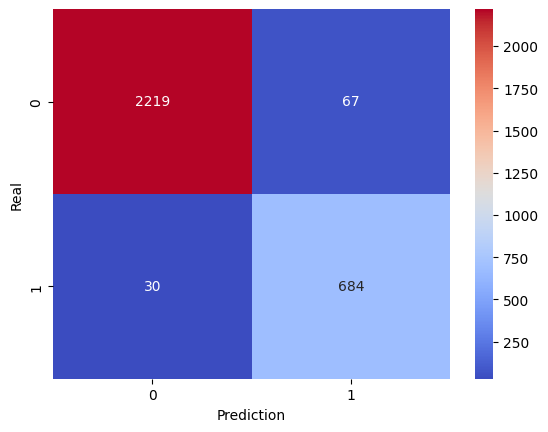

In [125]:
metrics_model_test(grid_4, X_train, y_train, X_test, y_test)

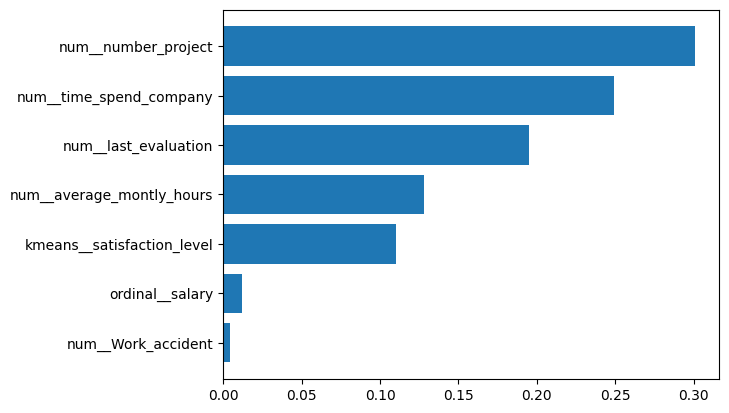

In [126]:
feature_importances_4 = grid_4.best_estimator_.named_steps['modelo'].feature_importances_
feature_names_4 = grid_4.best_estimator_.named_steps['preprocessor'].get_feature_names_out()

feature_importances_4_df = pd.DataFrame({'Feature': feature_names_4, 'Value': feature_importances_4}).sort_values(by=['Value'], ascending=True)

plt.barh(feature_importances_4_df['Feature'], feature_importances_4_df['Value']);

In [127]:
from sklearn.metrics import classification_report

print(classification_report(y_test, grid_4.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2286
           1       0.91      0.96      0.93       714

    accuracy                           0.97      3000
   macro avg       0.95      0.96      0.96      3000
weighted avg       0.97      0.97      0.97      3000



### Conclusão

O projeto alcançou seu objetivo, melhorando significativamente o recall do modelo final em comparação ao modelo inicial, permitindo classificar de forma eficiente potenciais colaboradores a deixarem a empresa para promover ações de mitigação.

Nota-se que o modelo entende que o departamento do colaborador não é relevante para uma pessoa deixar ou não a empresa.

A implementação de validações com dados reais é necessária para validar o impacto das ações preventivas sugeridas pelo modelo.

Talvez a aplicação de outros modelos podem trazer possíveis ganhos no desempenho, por exemplo o XGBoost, além da busca de novas variáveis. 